# Homework - Bayesian modeling - Part C (30 points)
## Implementing the Metropolis–Hastings algorithm for a Bayesian model of speech perception

by *Brenden Lake* and *Todd Gureckis*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

In this assignment, we examine a Bayesian model of speech perception and implement an approximate inference algorithm. As discussed in lecture, a "speaker" produces a speech sound $T$ (e.g., a vowel sound) intended for a "listener". Because of noise during tranmission, the listener doesn't hear $T$ exactly; instead, he hears the corrupted physical stimulus $S$. 
<img src="images/speech_bayesian_model.jpeg" style="width: 500px;"/>

The model postulates that the listener does a type of active reconstruction. Instead of verbatim perception of $S$, the listener aims to reconstruct the intended utterance $T$. Concretely, his/her perceptual system estimates $P(T|S)$, and this reconstructed stimulus is what they actually "hear." Reconstructing the details of the intended production is a good idea for a listener, since these details can be important for understanding what was said due to co-articulation.

This Bayesian model aims to explain the "perceptual magnet effect" in speech perception. This effect describes a particular kind of warping due to categorical representations. The phenomenon is that the perceived sound is closer to the category center than the raw stimulus $S$, in a way likened to a "perceptual magnet." In Bayesian terms, we will model this as computing the reconstruction as the expected value of $P(T|S)$ (which is denoted $E[T|S]$). See the figure below for an example.

<img src="images/speech_magnet_ex.jpeg" style="width: 450px;"/>

<div class="alert alert-info">
We strongly suggest you read the David MacKay chapter (in class readings), especially the section on Metropolis-Hastings, before proceeding with this assignment:
<br>    
<ul>
<li> MacKay, D. (2003). Chapter 29: Monte Carlo Methods. In Information Theory, Inference, and Learning Algorithms.
</li>
</ul>

The Bayesian model of the perceptual margnet effect was introduced in this paper:
<br>
<ul>
    <li>Feldman, N. H., & Griffiths, T. L. (2007). A rational account of the perceptual magnet effect. In Proceedings of the Annual Meeting of the Cognitive Science Society. (http://ling.umd.edu/~nhf/papers/PerceptualMagnet.pdf)</li>
</ul>
    


</div>

In [1]:
# Import the necessary packages
import numpy as np
import random
from scipy.stats import norm
from scipy.special import logsumexp
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Probabilistic model

Let's dive into the model details. First, we will need to set some key parameters.

In [2]:
# Key parameters we need for the probabilistic model
mu_c = 0 # category mean
sigma_c = 0.5 # category standard deviation
sigma2_c = sigma_c**2 # category variance
sigma_s = 0.4 # perceptual noise standard deviation
sigma2_s = sigma_s**2 # perceptual noise variance
X = np.linspace(-0.5,2,num=20) # points we are going to evaluate for warping

### Prior
Lets start with the prior. This is the distribution of utterances a speaker says when producing a particular speech sound (e.g., a specific vowel). The prior distribution $P(T)$ on speaker productions $T$ is modeled as a normal distribution

$$P(T) = N(\mu_c,\sigma^2_c).$$

This distribution is implemented in the `logprior_normal` function, which computes the log-probability. Although not necessary for this very simple case, it's important to ALWAYS compute with log-probabilities to prevent numerical underflow errors.

In [3]:
def logprior_normal(T):
    # Log-probability of speech production T
    return norm.logpdf(T,mu_c,sigma_c)

### Likelihood
The production $T$ is perturbed by noise to become the listener's perceived stimulus $S$. This noise process is also modeled as a normal distribution

$$P(S|T) = N(T,\sigma^2_S),$$

with the amount of noise governed by the standard deviation parameter $\sigma_S$. This distribution is implemented in `loglikelihood_normal`.

In [4]:
def loglikelihood_normal(S,T):
    # Log-probability of a stimulus S given production T
    return norm.logpdf(S,T,sigma_s)

### Posterior mean, for model with normal prior and normal likelihood
In this Bayesian model, we assume that the goal of the listener is to optimally infer the intended production $T$ given the perceived stimulus $S$. In other words, the listener is computing the posterior 

$$P(T|S)=\frac{P(S|T)P(T)}{P(S)}.$$

As the prior and likelihood are normally distributed, we have a "conjugate prior", meaning the posterior takes the same distributional form as the prior. Thus $P(T|S)$ is also normally distributed. If you work out the math (a great exercise for those interested!), the posterior is

$$P(T|S) = N(\frac{\sigma^2_c S + \sigma^2_S \mu_c}{\sigma^2_c + \sigma^2_S}, \frac{\sigma^2_c \sigma^2_S}{\sigma^2_c + \sigma^2_S}).$$

For the purposes of this assignment, we are only interested in the expected value (mean) of the posterior distribution, which is

$$E[T|S] = \frac{\sigma^2_c S + \sigma^2_S \mu_c}{\sigma^2_c + \sigma^2_S},$$

corresponding to the "best guess" of the unobservable intended production $T$.

Notice that this is a weighted average between the actual stimulus $S$ and the prior mean $\mu_c$. The form of this average is intuitive. If the perceptual noise is high (high $\sigma_S$), the listener relies more on her prior expectations of about what the speech sound typically sounds like, giving $\mu_c$ a higher weight. If the prior expectation is highly variable (high $\sigma_c$), the listener relies more heavily on the perceived stimulus $S$. These are predictions the model makes, which have been empirically verified.

We provide the function `post_mean_normal_normal` for computing this "best guess" expected value of the posterior. This function is only valid when both, prior and likelihood, are each represented by a normal distribution.

In [5]:
def post_mean_normal_normal(S):
    # Posterior mean E[T|S] of sound production T given signal S, given normal P(T) and P(S|T)
    return (sigma2_c*S+sigma2_s*mu_c)/(sigma2_c+sigma2_s)

## Visualizing the perceptual magnet effect
Let's see this Bayesian model in action. The `plot_warp` function visualizes how various raw stimulus values $S$ warp to become perceived values $E[T|S]$. For its arguments, the parameter `stimuli_eval` is a numpy array of all of the values of $S$ we want to evaluate. The function handle `f_posterior_mean` (see description below for a reminder about function handles) computes/estimates the posterior mean for a given stimulus $S$. The function handle `f_logprior` returns the log-probability of the prior for utterances $T$.

Let's run the `plot_warp` function for the normal-normal model that we have developed so far. The `post_mean_normal_normal` is the function handle for the posterior mean, and the function `logprior_normal` is the handle for the log prior.

This code produces a plot showing actual stimuli ($S$) at the top and perceived stimuli $E[T|S]$ at the bottom, overlaid with the category density $P(T)$ shown in blue. There is a clear "perceptual magnet effect" where perception warps the stimuli toward the category center.

<div class="alert alert-info">
Note: Function handles are pointers to a function which can be executed with the syntax `f_posterior_mean(S)` or `f_logprior(T)`. We need to pass handles, rather than pre-executed functions, so the script can control for itself when to execute the functions.
</div>

Normal-normal model with exact inference


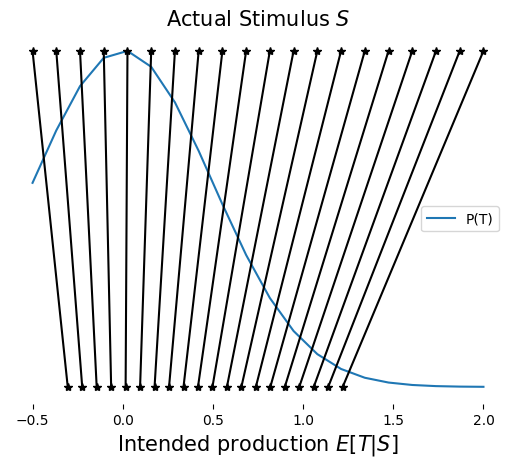

In [6]:
def plot_warp(f_posterior_mean,stimuli_eval,f_logprior,verbose=False):
    # Input
    #   f_posterior_mean : function handle f(S) that estimates posterior mean E[T|S] for a raw stimulus S
    #      (only works for scalar S)
    #   stimuli_eval : [numpy array] of raw stimuli S we want to evalute
    #   f_logprior : function handle f(T) that evaluates log-prior log P(T) for production T
    plt.figure()
    mypdf = np.exp(f_logprior(stimuli_eval))
    mx = np.max(mypdf)
    plt.plot(stimuli_eval,mypdf)
    for idx,x in enumerate(stimuli_eval):
        if verbose:
            print('  Estimating ' + str(idx+1) + ' of ' + str(len(stimuli_eval)) + ' stimuli S')
        x_new = f_posterior_mean(x)
        plt.plot([x,x_new],[mx,0.],'k*-')
    plt.legend(['P(T)'])
    plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=False, labelbottom=True)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.title('Actual Stimulus $S$',size=15)
    plt.xlabel('Intended production $E[T|S]$',size=15)

print('Normal-normal model with exact inference')
plot_warp(post_mean_normal_normal,X,logprior_normal)

## Approximate inference with Metropolis-Hastings algorithm

So far, we have developed a simple normal-normal model, where the posterior mean can be computed in closed form, e.g., via `post_mean_normal_normal`. Usually, we are not so lucky, and a closed form solution is not available. In most cases, approximate inference algorithms are needed. Here, you will implement the very general and powerful Metropolis-Hasting algorithm for approximate inference using Markov Chain Monte Carlo (MCMC). See your lecture slides for the algorithm specification.

Metropolis-Hastings (MH) constructs a sequence of samples that converges to the posterior $P(T|S)$, if the sequence is run for long enough. At each step, a new value of $T$ is proposed, and it is accepted or rejected based on its score using the MH "acceptance rule." Either way, the value of $T$ is stored as a sample, and another proposal is made at the next step. A certain number of samples is thrown away at the beginning of the chain (burn in), and the remaining can be used to approximate the posterior $P(T|S)$. In this case, we want to estimate the  posterior mean $E[T|S]$, so we average the samples with `np.mean(samples[nburn_in:])`.

<div class="alert alert-success" role="alert">
<h3> Problem 1 (20 points) </h3>
<br>
Fill in the missing code below for a MH sampler for estimating E[T|S].
<ul>
    <li>There should be produces `nsamp` samples total, but with `nburn_in` samples thrown out from the beginning of the sequence.</li>
    <li>New proposals are made from a normal distribution centered at the current value of `T` with standard deviation `prop_width`.</li>
</ul>
</div>
    
More information on Metropolis-Hastings can be found in the David MacKay chapter.

_Hint: Computing the acceptance ratio $a$ (see lecture slides) does not need to involve the normalizing constant $P(S)$ in the posterior, 
$$P(T|S)=\frac{P(S|T)P(T)}{P(S)}.$$
This constant does not depend on the the variable $T$, the variable we are sampling, and it cancels out in the numerator and denominator when computing the ratio $a$. Thus it does not need to be included. This is critical since for many probabilistic models, we don't know the normalizing constant and thus can't use it in the acceptance ratio. This is one reason why MCMC is such a useful tool for probabilistic inference._

Normal-normal model with MCMC inference
  Estimating 1 of 20 stimuli S
  Estimating 2 of 20 stimuli S
  Estimating 3 of 20 stimuli S
  Estimating 4 of 20 stimuli S
  Estimating 5 of 20 stimuli S
  Estimating 6 of 20 stimuli S
  Estimating 7 of 20 stimuli S
  Estimating 8 of 20 stimuli S
  Estimating 9 of 20 stimuli S
  Estimating 10 of 20 stimuli S
  Estimating 11 of 20 stimuli S
  Estimating 12 of 20 stimuli S
  Estimating 13 of 20 stimuli S
  Estimating 14 of 20 stimuli S
  Estimating 15 of 20 stimuli S
  Estimating 16 of 20 stimuli S
  Estimating 17 of 20 stimuli S
  Estimating 18 of 20 stimuli S
  Estimating 19 of 20 stimuli S
  Estimating 20 of 20 stimuli S


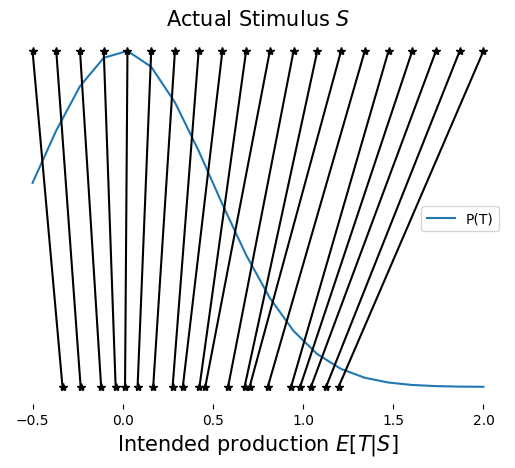

In [7]:
def estimate_metropolis_hastings(S,f_loglikelihood,f_logprior,nsamp=2000,nburn_in=100,prop_width=0.25):
    #
    #  Draw a sequence of samples T_(nburn_in), T_2, ..., T_nsamp from the posterior distribution P(T|S)
    #
    # Input
    #  S : actual stimulus (scalar value only)
    #  f_loglikelihood : function handle f(S,T) to log-likelihood log P(S|T)
    #  f_logprior : function handle f(t) to log-prior P(T)
    #  nsamp : how many samples to produce in MCMC chain
    #  nburn_in : how many samples at the beginning of the chain should we toss away
    #  prop_width : standard deviation of Gaussian proposal, centered at current value of T
    #
    assert(isinstance(S, float))
    samples = []
    # TODO: Your code goes here
    mu = 0
    post = lambda t: f_loglikelihood(S,t) + f_logprior(t)
    for i in range(nsamp):
        t = random.gauss(mu, prop_width)
        if post(t) > post(mu):
            samples.append(t)
            mu = t
        else:
            u = random.uniform(0, 1)
            if u < np.exp(post(t) - post(mu)):
                samples.append(t)
                mu = t
            else:
                samples.append(mu)
    return np.mean(samples[nburn_in:])

print('Normal-normal model with MCMC inference')
f_posterior_mean = lambda S : estimate_metropolis_hastings(S,loglikelihood_normal,logprior_normal)
plot_warp(f_posterior_mean,X,logprior_normal,verbose=True)

<div class="alert alert-success" role="alert">
<h3> Problem 2 (5 points) </h3>
<br>
Run your code from Problem 1 and examine the plot. Note that for each possible stimulus $S$, we run a different MCMC chain to estimate E[T|S].
<ul>
    <li>What is your reaction to the plot? How do the approximate estimates of E[T|S] using the sampler, compare to exact inference?</li>
    <li>What happens when you decrease the number of samples used in the MH algorithm?</li>
</ul>
</div>

Normal-normal model with MCMC inference and decreased samples used
  Estimating 1 of 20 stimuli S
  Estimating 2 of 20 stimuli S
  Estimating 3 of 20 stimuli S
  Estimating 4 of 20 stimuli S
  Estimating 5 of 20 stimuli S
  Estimating 6 of 20 stimuli S
  Estimating 7 of 20 stimuli S
  Estimating 8 of 20 stimuli S
  Estimating 9 of 20 stimuli S
  Estimating 10 of 20 stimuli S
  Estimating 11 of 20 stimuli S
  Estimating 12 of 20 stimuli S
  Estimating 13 of 20 stimuli S
  Estimating 14 of 20 stimuli S
  Estimating 15 of 20 stimuli S
  Estimating 16 of 20 stimuli S
  Estimating 17 of 20 stimuli S
  Estimating 18 of 20 stimuli S
  Estimating 19 of 20 stimuli S
  Estimating 20 of 20 stimuli S


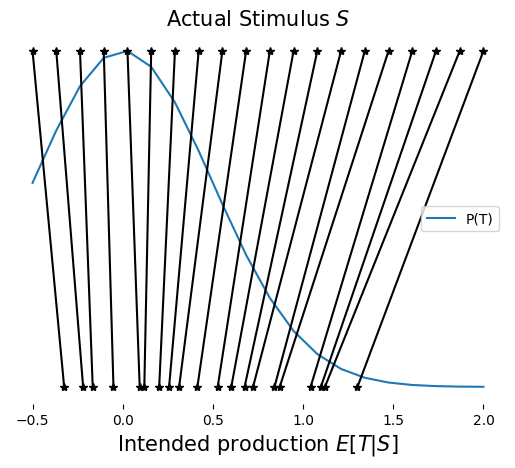

In [8]:
#Checking what happens after decreasing samples used
print('Normal-normal model with MCMC inference and decreased samples used')
f_posterior_mean = lambda S : estimate_metropolis_hastings(S,loglikelihood_normal,logprior_normal, nsamp=1000)
plot_warp(f_posterior_mean,X,logprior_normal,verbose=True)

YOUR RESPONSE GOES HERE

The exact inference, from its nature, has very evenly spaced points on the Intended production line. In contrast, the MH one is very similar as far as range and nearing the distribution, but still is more 'clumpy'.

Decreasing the number of samples seems to increase the 'clumpiness' further, making the new MH keep a similar range but is even more different from the exact inference solution. However it did, unsurprisingly, run twice as fast.

## Non-conjugate Bayesian model of speech perception

To demonstrate the power and generality of the Metropolis-Hastings algorithm, let's change the probabilistic model. Rather than using a normal distribution $P(T)$ over speaker utterances, let's assume we have a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) instead. It is unimodal like a normal distribution, but with fatter tails.

Use the code below to make a new plot. This time, we use the Laplace prior `logprior_laplace` over speaker utterances instead of the normal prior over utterances.

Laplace-normal model with MCMC inference
  Estimating 1 of 20 stimuli S
  Estimating 2 of 20 stimuli S
  Estimating 3 of 20 stimuli S
  Estimating 4 of 20 stimuli S
  Estimating 5 of 20 stimuli S
  Estimating 6 of 20 stimuli S
  Estimating 7 of 20 stimuli S
  Estimating 8 of 20 stimuli S
  Estimating 9 of 20 stimuli S
  Estimating 10 of 20 stimuli S
  Estimating 11 of 20 stimuli S
  Estimating 12 of 20 stimuli S
  Estimating 13 of 20 stimuli S
  Estimating 14 of 20 stimuli S
  Estimating 15 of 20 stimuli S
  Estimating 16 of 20 stimuli S
  Estimating 17 of 20 stimuli S
  Estimating 18 of 20 stimuli S
  Estimating 19 of 20 stimuli S
  Estimating 20 of 20 stimuli S


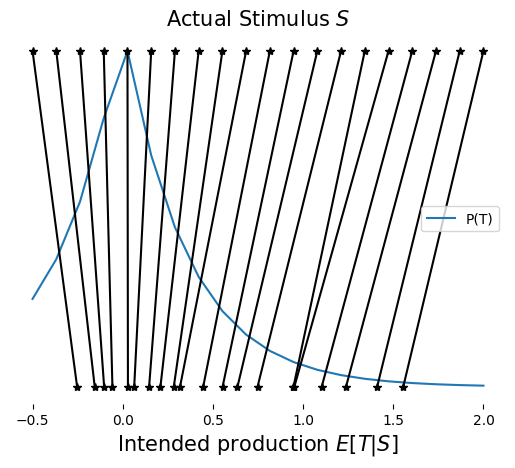

In [9]:
def logprior_laplace(T):
    # Alternative prior distribution
    #  log P(T|c) ~ Laplace(mu_c,b)
    b = sigma_c/np.sqrt(2)
    return (-np.abs(T-mu_c)/b) - np.log(2*b)

print('Laplace-normal model with MCMC inference')
f_posterior_mean = lambda S : estimate_metropolis_hastings(S,loglikelihood_normal,logprior_laplace)
plot_warp(f_posterior_mean,X,logprior_laplace,verbose=True)

<div class="alert alert-success" role="alert">
<h3> Problem 3 (5 points) </h3>
<ul>
    <li>What effect did replacing the prior have on the model?</li>
    <li>Is there a perceptual magnet effect with the Laplace prior? Does the Bayesian explanation of the phenomenon depend on having a normal prior?</li>
</ul>
</div>
</div>

YOUR RESPONSE HERE

Replacing the prior seems to have not only effected the range, but also where the points are drawn to. Where as before the points has a gradual tilt towards the prior's center, the sharper Laplace prior seems to group the Intended Production points more by its mean.

The Laplace Prior does seem to exhibit a small perceptual magnet effect here, so no: the Bayesian explanation does not seem to depend on a normal prior.